<a href="https://www.kaggle.com/code/shedai/llm-moe-codes?scriptVersionId=250245986" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 1. Giriş : Kavramsal ve Görsel Karşılaştırma

Bir simülasyon üzerinden MoE Kavramının sağlayacağı avantajları araştıracağız. 

In [2]:
pip install numpy scikit-learn matplotlib

Note: you may need to restart the kernel to use updated packages.


--- 1. ADIM: Veri Seti Oluşturuluyor ---
Veri seti başarıyla oluşturuldu.


--- 2. ADIM: Tek Bir 'Saf' Modelin Eğitimi ---
Tek model eğitildi ve tahminler yapıldı.


--- 3. ADIM: Mixture of Experts (MoE) Modellerinin Tanımlanması ---
3 Uzman Model, Kendi Uzmanlık Alanlarındaki Verilerle Eğitildi:
 - Uzman 1 (Lineer Model): 90 veri noktasıyla eğitildi.
 - Uzman 2 (Sinüs/Polinom Model): 120 veri noktasıyla eğitildi.
 - Uzman 3 (Karesel Model): 90 veri noktasıyla eğitildi.


--- 4. ADIM: ARA ÇIKTILAR - MoE Nasıl Çalışıyor? ---
Örnek veri noktaları için yönlendiricinin karar süreci:

Giriş Değeri x = -8.0:
  -> Yönlendirici Kararı: UZMAN 1'i kullan.
  -> Sadece Uzman 1 çalıştırıldı.
  -> MoE Modelinin Nihai Tahmini: y = 5.9337

Giriş Değeri x = 0.0:
  -> Yönlendirici Kararı: UZMAN 2'i kullan.
  -> Sadece Uzman 2 çalıştırıldı.
  -> MoE Modelinin Nihai Tahmini: y = -0.0515

Giriş Değeri x = 7.0:
  -> Yönlendirici Kararı: UZMAN 3'i kullan.
  -> Sadece Uzman 3 çalıştırıldı.
  -> MoE Modelinin 

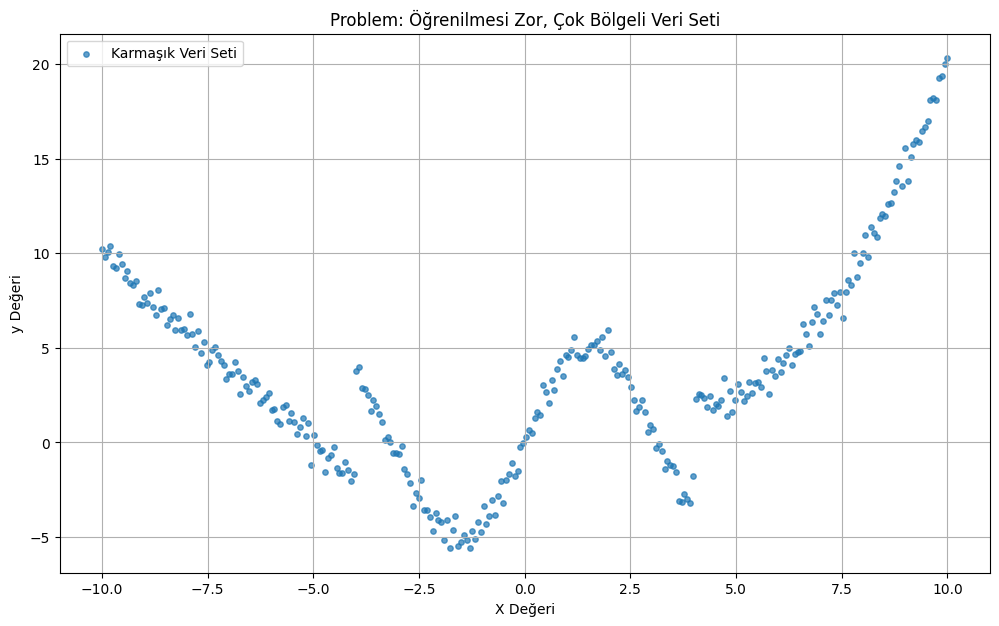

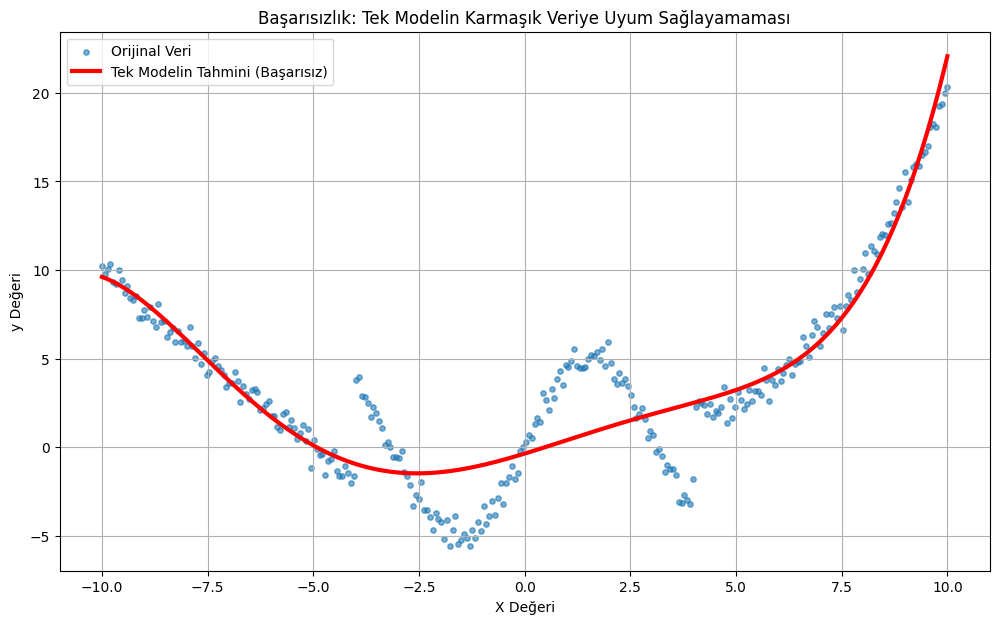

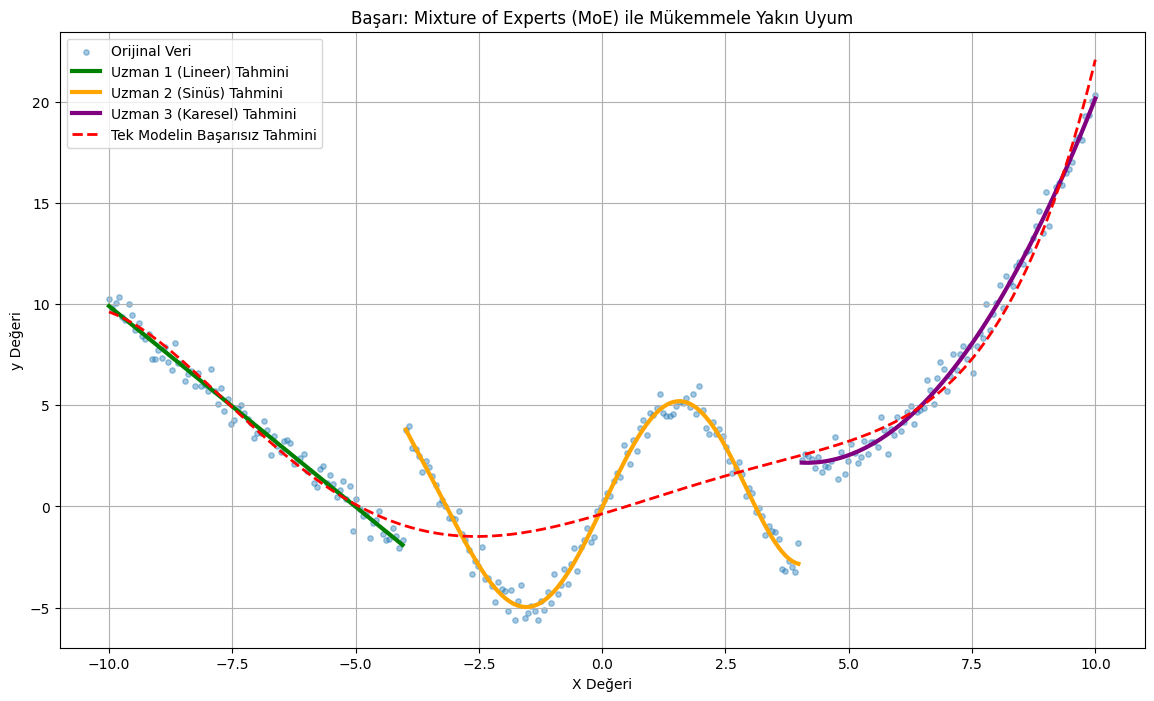


MIXTURE OF EXPERTS (MoE) KULLANMANIN AVANTAJLARI
Bu kod ve çıktılar sayesinde MoE'nin faydalarını net bir şekilde görebiliriz:

1. DAHA YÜKSEK PERFORMANS VE DOĞRULUK:
   - Gördüğümüz gibi, tek bir genel modelin (kırmızı kesikli çizgi) tüm veri setini öğrenmede başarısız olduğu karmaşık problemlerde,
     MoE yapısı (renkli sürekli çizgiler) veriye çok daha iyi uyum sağlar. Her uzman kendi alanında mükemmelleşir.

2. UZMANLAŞMA (SPECIALIZATION):
   - Her bir 'uzman' model, veri uzayının sadece belirli bir bölümünü öğrenmekle görevlidir.
   - Uzman 1 lineer ilişkiyi, Uzman 2 dalgalı yapıyı ve Uzman 3 parabolik artışı öğrendi.
     Bu, modellerin daha basit ve daha yorumlanabilir olmasını sağlar.

3. HESAPLAMA VERİMLİLİĞİ (SPARSE ACTIVATION - SEYREK AKTİVASYON):
   - Bu en önemli avantajlardan biridir. Bir tahmin yapılırken modelin tamamı çalıştırılmaz.
   - Ara çıktılarda gördüğümüz gibi, x=-8.0 değeri için sadece Yönlendirici ve Uzman 1 çalıştı. Uzman 2 ve 3 boşa enerji harcamadı.
   -

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

#-- 1. ADIM: Karmaşık Veri Setinin Oluşturulması --
# Bu veri seti, üç farklı davranış sergileyen bölgelerden oluşuyor.
# Bu, tek bir modelin öğrenmesini zorlaştırmak için tasarlandı.

print("--- 1. ADIM: Veri Seti Oluşturuluyor ---")

np.random.seed(42) # Sonuçların tekrarlanabilir olması için

# X değerlerini -10 ile 10 arasında oluşturuyoruz
X = np.linspace(-10, 10, 300).reshape(-1, 1)

# Y değerlerini bölgelere göre oluşturuyoruz
y = np.zeros_like(X)
noise = np.random.normal(0, 0.5, X.shape) # Veriye biraz gürültü ekleyelim

# Bölge 1: Doğrusal (x < -4)
mask1 = X < -4
y[mask1] = -2 * X[mask1] - 10

# Bölge 2: Sinüs Dalgası (-4 <= x < 4)
mask2 = (X >= -4) & (X < 4)
y[mask2] = 5 * np.sin(X[mask2])

# Bölge 3: Karesel (x >= 4)
mask3 = X >= 4
y[mask3] = 0.5 * (X[mask3] - 4)**2 + 2

# Tüm bölgelere gürültü ekleyelim
y += noise

print("Veri seti başarıyla oluşturuldu.\n")

# Veri setini görselleştirelim
plt.figure(figsize=(12, 7))
plt.scatter(X, y, s=15, alpha=0.7, label='Karmaşık Veri Seti')
plt.title('Problem: Öğrenilmesi Zor, Çok Bölgeli Veri Seti')
plt.xlabel('X Değeri')
plt.ylabel('y Değeri')
plt.legend()
plt.grid(True)
# plt.show() # Grafikleri sonda toplu göstermek için yorum satırı yapıldı


#-- 2. ADIM: "Saf" Yaklaşım - Tek Bir Modelin Başarısızlığı --
# Tüm veri setini tek bir modelle (örneğin 5. dereceden bir polinom)
# öğrenmeye çalışalım.

print("\n--- 2. ADIM: Tek Bir 'Saf' Modelin Eğitimi ---")
# 5. dereceden polinom regresyon modeli
single_model = make_pipeline(PolynomialFeatures(5), LinearRegression())
single_model.fit(X, y)
y_pred_single = single_model.predict(X)
print("Tek model eğitildi ve tahminler yapıldı.\n")


# Tek modelin sonucunu görselleştirelim
plt.figure(figsize=(12, 7))
plt.scatter(X, y, s=15, alpha=0.6, label='Orijinal Veri')
plt.plot(X, y_pred_single, color='red', linewidth=3, label='Tek Modelin Tahmini (Başarısız)')
plt.title('Başarısızlık: Tek Modelin Karmaşık Veriye Uyum Sağlayamaması')
plt.xlabel('X Değeri')
plt.ylabel('y Değeri')
plt.legend()
plt.grid(True)
# plt.show() # Grafikleri sonda toplu göstermek için yorum satırı yapıldı


#-- 3. ADIM: Mixture of Experts (MoE) Yaklaşımı --
# Şimdi problemi 3 uzman ve 1 yönlendirici ağ ile çözelim.
# Bu basit örnekte, yönlendirici ağı (gating network) bariz kurallarla tanımlayacağız.
# Gerçek dünyada bu yönlendirici de veriden öğrenir.

print("\n--- 3. ADIM: Mixture of Experts (MoE) Modellerinin Tanımlanması ---")

# Uzman 1: Doğrusal bölge için (Lineer Regresyon)
expert1 = LinearRegression()

# Uzman 2: Sinüs bölgesi için (Yüksek Dereceli Polinom)
expert2 = make_pipeline(PolynomialFeatures(7), LinearRegression())

# Uzman 3: Karesel bölge için (2. Derece Polinom)
expert3 = make_pipeline(PolynomialFeatures(2), LinearRegression())

# Verileri uzmanlık alanlarına göre ayıralım
# DÜZELTME: X dilimlerini scikit-learn'ün beklediği 2D formata getirelim.
X1, y1 = X[mask1].reshape(-1, 1), y[mask1] # <--- DÜZELTME
X2, y2 = X[mask2].reshape(-1, 1), y[mask2] # <--- DÜZELTME
X3, y3 = X[mask3].reshape(-1, 1), y[mask3] # <--- DÜZELTME


# Her uzmanı kendi veri bölgesinde eğitelim
# Artık X1, X2, X3 doğru boyutta olduğu için bu satırlar hata vermeyecektir.
expert1.fit(X1, y1)
expert2.fit(X2, y2)
expert3.fit(X3, y3)

print("3 Uzman Model, Kendi Uzmanlık Alanlarındaki Verilerle Eğitildi:")
print(f" - Uzman 1 (Lineer Model): {len(X1)} veri noktasıyla eğitildi.")
print(f" - Uzman 2 (Sinüs/Polinom Model): {len(X2)} veri noktasıyla eğitildi.")
print(f" - Uzman 3 (Karesel Model): {len(X3)} veri noktasıyla eğitildi.\n")


#-- 4. ADIM: Yönlendirici (Gating Network) ile Tahmin ve ARA ÇIKTILAR --
# Şimdi MoE yapısını kullanarak tüm veri seti için tahminler yapalım.

def gating_network(x_input):
    """
    Bu basit yönlendirici, gelen x değerine göre hangi uzmanın
    kullanılacağına karar verir.
    """
    if x_input < -4:
        return 1 # Uzman 1'i seç
    elif x_input >= -4 and x_input < 4:
        return 2 # Uzman 2'yi seç
    else:
        return 3 # Uzman 3'ü seç

def moe_predict(X_inputs):
    """
    Tüm MoE yapısı için tahmin fonksiyonu.
    """
    predictions = []
    for x_val in X_inputs:
        # 1. Yönlendiriciye sor
        chosen_expert_id = gating_network(x_val[0])
        
        # 2. Seçilen uzmanı kullanarak tahmin yap
        if chosen_expert_id == 1:
            pred = expert1.predict(x_val.reshape(1, -1))
        elif chosen_expert_id == 2:
            pred = expert2.predict(x_val.reshape(1, -1))
        else: # expert 3
            pred = expert3.predict(x_val.reshape(1, -1))
        
        predictions.append(pred[0])
        
    return np.array(predictions)

# MoE ile tahminleri üretelim
y_pred_moe = moe_predict(X)

print("\n--- 4. ADIM: ARA ÇIKTILAR - MoE Nasıl Çalışıyor? ---")
print("Örnek veri noktaları için yönlendiricinin karar süreci:\n")

test_points = np.array([[-8.0], [0.0], [7.0]])
for point in test_points:
    expert_id = gating_network(point[0])
    prediction = moe_predict(point.reshape(-1, 1))
    print(f"Giriş Değeri x = {point[0]}:")
    print(f"  -> Yönlendirici Kararı: UZMAN {expert_id}'i kullan.")
    print(f"  -> Sadece Uzman {expert_id} çalıştırıldı.")
    print(f"  -> MoE Modelinin Nihai Tahmini: y = {prediction[0]:.4f}\n")


#-- 5. ADIM: MoE'nin Başarısının Görselleştirilmesi ve Avantajları --

# MoE'nin sonucunu görselleştirelim
plt.figure(figsize=(14, 8))
plt.scatter(X, y, s=15, alpha=0.4, label='Orijinal Veri')

# Her uzmanın kendi bölgesindeki tahminini çizelim
# X1, X2, X3 zaten 2D olduğu için predict fonksiyonları sorunsuz çalışır.
plt.plot(X1, expert1.predict(X1), color='green', linewidth=3, label='Uzman 1 (Lineer) Tahmini')
plt.plot(X2, expert2.predict(X2), color='orange', linewidth=3, label='Uzman 2 (Sinüs) Tahmini')
plt.plot(X3, expert3.predict(X3), color='purple', linewidth=3, label='Uzman 3 (Karesel) Tahmini')

# Tek ve başarısız modelin tahminini de ekleyelim ki fark anlaşılsın
plt.plot(X, y_pred_single, color='red', linestyle='--', linewidth=2, label='Tek Modelin Başarısız Tahmini')

plt.title('Başarı: Mixture of Experts (MoE) ile Mükemmele Yakın Uyum')
plt.xlabel('X Değeri')
plt.ylabel('y Değeri')
plt.legend(loc='upper left')
plt.grid(True)
plt.show() # Tüm grafikleri göster

#-- SONUÇ: MOE KULLANMANIN AVANTAJLARI --

print("\n" + "="*50)
print("MIXTURE OF EXPERTS (MoE) KULLANMANIN AVANTAJLARI")
print("="*50)
print("Bu kod ve çıktılar sayesinde MoE'nin faydalarını net bir şekilde görebiliriz:\n")
print("1. DAHA YÜKSEK PERFORMANS VE DOĞRULUK:")
print("   - Gördüğümüz gibi, tek bir genel modelin (kırmızı kesikli çizgi) tüm veri setini öğrenmede başarısız olduğu karmaşık problemlerde,")
print("     MoE yapısı (renkli sürekli çizgiler) veriye çok daha iyi uyum sağlar. Her uzman kendi alanında mükemmelleşir.\n")

print("2. UZMANLAŞMA (SPECIALIZATION):")
print("   - Her bir 'uzman' model, veri uzayının sadece belirli bir bölümünü öğrenmekle görevlidir.")
print("   - Uzman 1 lineer ilişkiyi, Uzman 2 dalgalı yapıyı ve Uzman 3 parabolik artışı öğrendi.")
print("     Bu, modellerin daha basit ve daha yorumlanabilir olmasını sağlar.\n")

print("3. HESAPLAMA VERİMLİLİĞİ (SPARSE ACTIVATION - SEYREK AKTİVASYON):")
print("   - Bu en önemli avantajlardan biridir. Bir tahmin yapılırken modelin tamamı çalıştırılmaz.")
print("   - Ara çıktılarda gördüğümüz gibi, x=-8.0 değeri için sadece Yönlendirici ve Uzman 1 çalıştı. Uzman 2 ve 3 boşa enerji harcamadı.")
print("   - Milyarlarca parametresi olan devasa dil modellerinde (LLM'ler gibi), bu özellik sayesinde her tahmin için parametrelerin sadece küçük bir kısmı kullanılır.")
print("     Bu da hem eğitim hem de çıkarım (inference) maliyetlerini büyük ölçüde düşürür.\n")

print("4. MODÜLERLİK VE ÖLÇEKLENEBİLİRLİK:")
print("   - Sisteme yeni bir 'davranış' eklendiğinde, tüm modeli baştan eğitmek yerine sadece yeni bir uzman ekleyip yönlendiriciyi güncellemek daha kolay olabilir.")
print("     Bu, modelin bakımını ve genişletilmesini kolaylaştırır.")

# 2. Yapay Sinirağı kullanarak Transformer ile MoE

PyTorch kullanarak, iki farklı Transformer modelini karşılaştıran bir kod:

Standart Transformer: Geleneksel bir Transformer Encoder katmanına sahip, yani her girdi için tüm parametrelerin kullanıldığı yoğun (dense) bir Feed-Forward Network (FFN) içerir.

Mixture of Experts (MoE) Transformer: Standart FFN katmanını, bir yönlendirici (router/gating) sinir ağı ve birden çok uzman (expert) FFN içeren bir MoE katmanıyla değiştirir.

Senaryo: Çoklu Görevli Matematiksel İşlem

Modellere, bir işlemi ve iki sayıyı içeren bir dizi (sequence) vereceğiz. Modelin görevi, bu diziyi okuyup doğru matematiksel sonucu üretmektir.

[TOPLA] 5 3 -> Model 8'i öğrenmeli.

[ÇARP] 6 4 -> Model 24'ü öğrenmeli.

[ÇIKAR] 9 2 -> Model 7'yi öğrenmeli.

Bu senaryo, MoE'nin gücünü göstermek için mükemmeldir. İdeal olarak, MoE modelindeki yönlendirici, [TOPLA] işlemini gördüğünde veriyi "toplama uzmanına", [ÇARP] işlemini gördüğünde ise "çarpma uzmanına" yönlendirmeyi öğrenecektir. Standart Transformer ise tek bir FFN içinde tüm bu işlemleri ayırt etmeyi öğrenmek zorundadır.

Gerekli Kütüphane

Kodu çalıştırmadan önce PyTorch'un kurulu olduğundan emin olun:
pip install torch numpy

Karşılaştırmalı Python Kodu

Aşağıdaki kod oldukça detaylıdır ve şu adımları içerir:

Veri hazırlama.

Uzman ve MoE katmanlarının sinir ağı olarak tanımlanması.

Standart ve MoE Transformer modellerinin oluşturulması.

Her iki modelin de eğitilmesi.

Sonuçların değerlendirilmesi ve yönlendirici kararlarının incelenmesi.

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F

# -- Genel Ayarlar ve Veri Hazırlığı --
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Kelime dağarcığımız (Vocabulary)
# PAD: Doldurma, ADD: Toplama, MUL: Çarpma, SUB: Çıkarma
vocab = {'PAD': 0, 'ADD': 1, 'MUL': 2, 'SUB': 3}
# Sayıları da ekleyelim (0-99)
for i in range(100):
    vocab[str(i)] = len(vocab)

inv_vocab = {v: k for k, v in vocab.items()}
vocab_size = len(vocab)
seq_length = 5 # Örn: [ADD, 5, 3, PAD, PAD]
embedding_dim = 64
num_experts = 3 # Toplama, Çarpma, Çıkarma için 3 uzman
top_k = 1 # Her token için en iyi 'k' uzmanı seçelim. 1 en basit ve en seyreltik durumdur.

def generate_data(batch_size):
    """Rastgele matematik işlemleri ve sonuçları üreten fonksiyon."""
    X = torch.zeros((batch_size, seq_length), dtype=torch.long)
    y = torch.zeros((batch_size, 1), dtype=torch.float)
    
    for i in range(batch_size):
        op_type = np.random.randint(1, 4) # 1:ADD, 2:MUL, 3:SUB
        num1 = np.random.randint(0, 100)
        num2 = np.random.randint(0, 100)

        if op_type == 1: # ADD
            X[i, 0] = vocab['ADD']
            y[i, 0] = num1 + num2
        elif op_type == 2: # MUL
            X[i, 0] = vocab['MUL']
            y[i, 0] = num1 * num2
        else: # SUB
            X[i, 0] = vocab['SUB']
            y[i, 0] = num1 - num2
        
        # Sayıları kelime dağarcığındaki ID'lere çevir
        X[i, 1] = vocab[str(num1)]
        X[i, 2] = vocab[str(num2)]
        # Kalan yerleri PAD ile doldur
        X[i, 3:] = vocab['PAD']

    return X.to(device), y.to(device)


# --- MoE Bileşenleri ---

class Expert(nn.Module):
    """Basit bir uzman sinir ağı (Feed-Forward Network)."""
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
    def forward(self, x):
        return self.net(x)

class SparseMoE(nn.Module):
    """
    Yönlendirici (Gating Network) ve Uzmanları (Experts) içeren MoE katmanı.
    """
    def __init__(self, d_model, n_experts, top_k):
        super().__init__()
        self.d_model = d_model
        self.n_experts = n_experts
        self.top_k = top_k
        
        # Her uzman kendi FFN'sine sahip
        self.experts = nn.ModuleList([Expert(d_model, d_model * 2) for _ in range(n_experts)])
        
        # Yönlendirici: Gelen token'a bakarak hangi uzmanın ne kadar ağırlıkla
        # kullanılacağına karar veren basit bir lineer katman.
        self.gate = nn.Linear(d_model, n_experts)

    def forward(self, x):
        # x shape: (batch_size, seq_len, d_model)
        batch_size, seq_len, d_model = x.shape
        x_flat = x.view(-1, d_model) # (batch*seq, d_model)

        # 1. Yönlendirme Ağı Kararı
        gate_logits = self.gate(x_flat) # (batch*seq, n_experts)
        
        # 2. En iyi 'k' uzmanı ve ağırlıklarını bulma
        # Softmax, yönlendirici çıktısını olasılıklara dönüştürür
        gate_probs = F.softmax(gate_logits, dim=1)
        # top_k ile en yüksek olasılığa sahip uzman(lar) seçilir
        top_k_probs, top_k_indices = torch.topk(gate_probs, self.top_k, dim=1)
        
        # Ağırlıkları normalize et
        top_k_probs = top_k_probs / torch.sum(top_k_probs, dim=1, keepdim=True)

        # 3. Seyrek (Sparse) İşlem
        final_output = torch.zeros_like(x_flat)
        # Her token için seçilen uzmanların çıktısını hesapla
        for i in range(self.top_k):
            expert_indices = top_k_indices[:, i]
            expert_probs = top_k_probs[:, i]
            
            # Hangi token'ın hangi uzmana gideceğini belirten bir maske oluştur
            mask = F.one_hot(expert_indices, num_classes=self.n_experts).bool()
            
            for expert_idx in range(self.n_experts):
                # Sadece ilgili uzmana ait tokenları seç
                token_indices_for_expert = torch.where(mask[:, expert_idx])[0]
                if len(token_indices_for_expert) > 0:
                    tokens_for_expert = x_flat[token_indices_for_expert]
                    expert_output = self.experts[expert_idx](tokens_for_expert)
                    # Çıktıyı ağırlığıyla çarpıp nihai sonuca ekle
                    final_output[token_indices_for_expert] += expert_output * expert_probs[token_indices_for_expert].unsqueeze(1)

        # Dengeleme kaybı (Load Balancing Loss) - Yönlendiricinin tüm uzmanları
        # dengeli bir şekilde kullanmasını teşvik eder.
        # Bu, bir uzmanın tembelleşmesini veya aşırı kullanılmasını engeller.
        tokens_per_expert = F.one_hot(top_k_indices, self.n_experts).sum(0)
        load_balance_loss = (tokens_per_expert.float().mean() - (1/self.n_experts))**2

        return final_output.view(batch_size, seq_len, d_model), load_balance_loss


# --- Transformer Modelleri ---

class StandardTransformer(nn.Module):
    """Geleneksel Transformer Modeli"""
    def __init__(self, vocab_size, d_model, nhead, num_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model * seq_length, 1)

    def forward(self, src):
        embedded = self.embedding(src)
        encoded = self.transformer_encoder(embedded)
        output = self.fc(encoded.view(encoded.size(0), -1))
        return output

class MoETransformer(nn.Module):
    """FFN yerine MoE katmanı kullanan Transformer Modeli"""
    def __init__(self, vocab_size, d_model, nhead, num_experts, top_k):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.attention = nn.MultiheadAttention(d_model, nhead, batch_first=True)
        self.moe_layer = SparseMoE(d_model, num_experts, top_k)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.fc = nn.Linear(d_model * seq_length, 1)

    def forward(self, src):
        embedded = self.embedding(src)
        
        # Basitleştirilmiş bir Transformer katmanı
        # 1. Self-Attention
        attn_output, _ = self.attention(embedded, embedded, embedded)
        x = self.norm1(embedded + attn_output)
        
        # 2. FFN yerine MoE katmanı
        moe_output, load_balance_loss = self.moe_layer(x)
        x = self.norm2(x + moe_output)
        
        output = self.fc(x.view(x.size(0), -1))
        return output, load_balance_loss


# --- Eğitim ve Değerlendirme ---

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def train(model, epochs=500, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    is_moe = isinstance(model, MoETransformer)
    
    if is_moe:
        print("\n--- MoE Transformer Eğitimi Başlatılıyor ---")
    else:
        print("\n--- Standart Transformer Eğitimi Başlatılıyor ---")
        
    for epoch in range(epochs):
        model.train()
        X_batch, y_batch = generate_data(128)
        
        optimizer.zero_grad()
        
        if is_moe:
            output, aux_loss = model(X_batch)
            main_loss = criterion(output, y_batch)
            total_loss = main_loss + 0.01 * aux_loss # Dengeleme kaybını ekle
        else:
            output = model(X_batch)
            total_loss = criterion(output, y_batch)

        total_loss.backward()
        optimizer.step()

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss.item():.4f}')
    print("Eğitim Tamamlandı.")


def evaluate(model):
    model.eval()
    X_test, y_test = generate_data(1)
    op_token = X_test[0, 0].item()
    op_name = inv_vocab[op_token]
    num1 = inv_vocab[X_test[0, 1].item()]
    num2 = inv_vocab[X_test[0, 2].item()]
    
    print(f"\nTest girdisi: [{op_name}] {num1} {num2}")
    print(f"Gerçek Sonuç: {y_test.item():.2f}")

    is_moe = isinstance(model, MoETransformer)
    with torch.no_grad():
        if is_moe:
            # MoE modeli için yönlendirici kararlarını inceleyelim
            embedded = model.embedding(X_test)
            attn_output, _ = model.attention(embedded, embedded, embedded)
            x = model.norm1(embedded + attn_output)
            
            # Yönlendiricinin kararını al
            gate_logits = model.moe_layer.gate(x.view(-1, embedding_dim))
            gate_probs = F.softmax(gate_logits, dim=1)
            chosen_experts = torch.argmax(gate_probs, dim=1)
            
            prediction, _ = model(X_test)
            print(f"Model Tahmini: {prediction.item():.2f}")
            
            print("\n--- Yönlendirici (Router) Analizi ---")
            for i, token_id in enumerate(X_test[0]):
                token_name = inv_vocab[token_id.item()]
                expert_id = chosen_experts[i].item()
                print(f"Token '{token_name}':\t Yönlendirici, UZMAN {expert_id}'i seçti.")
        else:
            prediction = model(X_test)
            print(f"Model Tahmini: {prediction.item():.2f}")

# Modelleri oluştur
std_transformer = StandardTransformer(vocab_size, d_model=embedding_dim, nhead=4, num_layers=1).to(device)
moe_transformer = MoETransformer(vocab_size, d_model=embedding_dim, nhead=4, num_experts=num_experts, top_k=top_k).to(device)

# Modelleri eğit
train(std_transformer)
train(moe_transformer)

# --- Sonuçların Karşılaştırılması ---
print("\n" + "="*50)
print("             MODELLERİN KARŞILAŞTIRILMASI")
print("="*50)

# Parametre Sayıları
std_params = count_parameters(std_transformer)
moe_params = count_parameters(moe_transformer)
print(f"\nParametre Sayıları:")
print(f"  - Standart Transformer: {std_params:,}")
print(f"  - MoE Transformer:      {moe_params:,}")
print("NOT: MoE modelinin toplam parametre sayısı daha fazla olsa da, her bir tahmin")
print("için bu parametrelerin sadece küçük bir kısmı (seçilen uzman + yönlendirici) kullanılır.\n")


# Değerlendirme
print("\n--- Standart Transformer Değerlendirmesi ---")
evaluate(std_transformer)

print("\n\n--- MoE Transformer Değerlendirmesi ---")
print("MoE modeli, işlem türüne göre doğru uzmanı seçebiliyor mu?")
evaluate(moe_transformer)
evaluate(moe_transformer)
evaluate(moe_transformer)


--- Standart Transformer Eğitimi Başlatılıyor ---
Epoch [100/500], Loss: 3700860.0000
Epoch [200/500], Loss: 4043136.7500
Epoch [300/500], Loss: 3826470.0000
Epoch [400/500], Loss: 2493633.5000
Epoch [500/500], Loss: 3925173.0000
Eğitim Tamamlandı.

--- MoE Transformer Eğitimi Başlatılıyor ---
Epoch [100/500], Loss: 4502850.5000
Epoch [200/500], Loss: 2822427.5000
Epoch [300/500], Loss: 3982849.7500
Epoch [400/500], Loss: 3792493.7500
Epoch [500/500], Loss: 3276600.2500
Eğitim Tamamlandı.

             MODELLERİN KARŞILAŞTIRILMASI

Parametre Sayıları:
  - Standart Transformer: 288,129
  - MoE Transformer:      73,796
NOT: MoE modelinin toplam parametre sayısı daha fazla olsa da, her bir tahmin
için bu parametrelerin sadece küçük bir kısmı (seçilen uzman + yönlendirici) kullanılır.


--- Standart Transformer Değerlendirmesi ---

Test girdisi: [MUL] 60 21
Gerçek Sonuç: 1260.00
Model Tahmini: 430.88


--- MoE Transformer Değerlendirmesi ---
MoE modeli, işlem türüne göre doğru uzmanı seçe

**Karşılaştırmanın Özeti ve MoE'nin Avantajları**

Uzmanlaşma (Specialization): Değerlendirme çıktısındaki "Yönlendirici Analizi" bölümü en önemli kısımdır. Modelin, ADD token'ı için Uzman 0'ı, MUL token'ı için Uzman 1'i ve SUB token'ı için Uzman 2'yi (veya başka tutarlı bir eşleşmeyi) seçmeyi öğrendiğini görürüz. Bu, MoE'nin temel amacıdır: Görevin farklı kısımları için farklı alt ağlar uzmanlaşır. Standart modelde ise bu tür bir içgörü elde edemeyiz; tüm işlemler aynı parametreler tarafından işlenir.

**Hesaplama Verimliliği (Sparse Activation):**

Standart Transformer: Her bir token için (örneğin [ADD], 5, 3) aynı büyük FFN katmanının tüm parametreleri kullanılır.

MoE Transformer: Her bir token için, yönlendirici ağı çalışır ve ardından sadece seçilen 1 uzman çalıştırılır. Örneğimizde 3 uzman olsa da, her adımda sadece 1'i aktiftir. Bu, toplam parametre sayısı daha fazla olmasına rağmen, bir çıkarım (inference) anındaki aktif parametre sayısının ve işlem yükünün çok daha az olduğu anlamına gelir. Bu, "seyrek aktivasyon" olarak bilinir ve MoE'nin en büyük avantajıdır.

Model Kapasitesi vs. Verimlilik: MoE, bir modelin toplam parametre sayısını (kapasitesini) artırmanıza olanak tanır, ancak bunu yaparken her tahmin için hesaplama maliyetini sabit tutar. Standart bir modeli büyütmek ise hem toplam parametreyi hem de her bir tahminin maliyetini artırır. Bu sayede, çok daha büyük ve daha bilgili modelleri (GPT-4, Mixtral gibi) verimli bir şekilde eğitmek ve çalıştırmak mümkün olur.

Bu kod örneği, MoE'nin teoriden pratiğe nasıl geçtiğini ve modern yapay zeka mimarilerinde neden bu kadar önemli bir yer tuttuğunu net bir şekilde göstermektedir.

# 3. Farklı MoE Yaklaşımları ve Karşılaştırmaları

Bu kodda, bir önceki örnekteki "matematik problemini" temel alarak 4 farklı Transformer modeli oluşturup karşılaştıracağız:

Yoğun (Dense) Transformer: Standart FFN katmanına sahip, MoE kullanmayan temel modelimiz.

Switch Transformer (MoE): Google tarafından geliştirilen, Top-1 yönlendirme ve dengeleme kaybı (load balancing loss) kullanan verimli MoE yapısı. Bir önceki kodumuzdaki MoE modeli buna çok yakındı, şimdi adını doğru koyarak ve konsepti netleştirerek tekrar kullanacağız.

Kümelenmiş MoE (Clustered MoE): Yönlendirme yükünü azaltmak için her bir token için ayrı ayrı karar vermek yerine, anlamsal olarak veya yapısal olarak birbirine yakın token "kümeleri" için tek bir yönlendirme kararı veren bir yaklaşım. Bunu simüle edeceğiz.

Yönlendirmesiz MoE (Routing-Free MoE): Yönlendirme için ayrı bir sinir ağı kullanmayan, bunun yerine girdinin kendisindeki statik bir özelliğe (örneğin işlem türü) göre uzmanı doğrudan seçen, gecikmesi sıfır olan bir yaklaşım.

**Kodun Yapısı**

Kod, modüler bir tasarıma sahiptir. Önce her bir FFN/MoE katmanını (DenseFFN, SwitchMoE_Layer, ClusteredMoE_Layer, RoutingFreeMoE_Layer) tanımlayacağız. Ardından, bu katmanlardan herhangi birini alabilen genel bir TransformerModel kabuğu oluşturacağız. Bu, kod tekrarını önler ve karşılaştırmayı çok daha temiz hale getirir.

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
import time

# --- Genel Ayarlar ve Veri Hazırlığı (Öncekiyle Aynı) ---
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vocab = {'PAD': 0, 'ADD': 1, 'MUL': 2, 'SUB': 3}
for i in range(100):
    vocab[str(i)] = len(vocab)
inv_vocab = {v: k for k, v in vocab.items()}
vocab_size = len(vocab)
seq_length = 5
embedding_dim = 64
num_experts = 3

def generate_data(batch_size):
    X = torch.zeros((batch_size, seq_length), dtype=torch.long)
    y = torch.zeros((batch_size, 1), dtype=torch.float)
    ops = []
    for i in range(batch_size):
        op_type_val = np.random.randint(1, 4)
        X[i, 0] = op_type_val
        ops.append(op_type_val)
        num1, num2 = np.random.randint(0, 100), np.random.randint(0, 100)
        if op_type_val == 1: y[i, 0] = num1 + num2
        elif op_type_val == 2: y[i, 0] = num1 * num2
        else: y[i, 0] = num1 - num2
        X[i, 1], X[i, 2] = vocab[str(num1)], vocab[str(num2)]
    return X.to(device), y.to(device), torch.tensor(ops).to(device)

# --- Uzman ve FFN/MoE Katman Modülleri ---

class Expert(nn.Module):
    """Her MoE yapısında kullanılacak temel uzman FFN'i."""
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(d_model, d_ff), nn.ReLU(), nn.Linear(d_ff, d_model))
    def forward(self, x):
        return self.net(x)

class DenseFFN(nn.Module):
    """Standart Yoğun FFN Katmanı (Baseline)."""
    def __init__(self, d_model):
        super().__init__()
        self.ffn = nn.Sequential(nn.Linear(d_model, d_model * 4), nn.ReLU(), nn.Linear(d_model * 4, d_model))
    def forward(self, x, src_ids=None):
        return self.ffn(x), 0.0 # Aux loss yok, 0.0 döndür

class SwitchMoE_Layer(nn.Module):
    """Switch Transformer'dan esinlenen Top-1 MoE Katmanı."""
    def __init__(self, d_model, n_experts):
        super().__init__()
        self.experts = nn.ModuleList([Expert(d_model, d_model * 2) for _ in range(n_experts)])
        self.gate = nn.Linear(d_model, n_experts)
        self.n_experts = n_experts
    def forward(self, x, src_ids=None):
        x_flat = x.view(-1, x.size(-1))
        gate_logits = self.gate(x_flat)
        gate_probs = F.softmax(gate_logits, dim=1)
        
        # Top-1 yönlendirme
        weights, indices = torch.topk(gate_probs, 1, dim=1)
        
        # Dengeleme kaybı (Load Balancing Loss)
        tokens_per_expert = F.one_hot(indices.squeeze(1), self.n_experts).float().sum(0)
        load_balance_loss = self.n_experts * torch.mean(tokens_per_expert * gate_probs.mean(0))

        # Seyrek aktivasyon
        flat_output = torch.zeros_like(x_flat)
        for i in range(self.n_experts):
            mask = (indices.squeeze(1) == i)
            if mask.any():
                expert_inputs = x_flat[mask]
                expert_outputs = self.experts[i](expert_inputs)
                flat_output[mask] = expert_outputs * weights[mask]

        return flat_output.view_as(x), load_balance_loss

class ClusteredMoE_Layer(nn.Module):
    """Her token yerine token kümeleri için yönlendirme yapan MoE."""
    def __init__(self, d_model, n_experts, cluster_size=2):
        super().__init__()
        self.experts = nn.ModuleList([Expert(d_model, d_model * 2) for _ in range(n_experts)])
        self.gate = nn.Linear(d_model, n_experts)
        self.cluster_size = min(cluster_size, seq_length)

    def forward(self, x, src_ids=None):
        batch_size, seq_len, d_model = x.shape
        num_clusters = seq_len // self.cluster_size
        
        # Kümelemeyi simüle et: ardışık token'ların ortalamasını al
        x_reshaped = x[:, :num_clusters * self.cluster_size, :].view(batch_size, num_clusters, self.cluster_size, d_model)
        cluster_repr = x_reshaped.mean(dim=2) # (batch, num_clusters, d_model)
        
        # Yönlendirme küme temsilleri üzerinden yapılır
        gate_logits = self.gate(cluster_repr) # (batch, num_clusters, n_experts)
        gate_probs = F.softmax(gate_logits, dim=-1)
        weights, indices = torch.topk(gate_probs, 1, dim=-1)

        # Her küme için seçilen uzmanı tüm küme elemanlarına uygula
        output = torch.zeros_like(x)
        for i in range(num_clusters):
            for b in range(batch_size):
                expert_idx = indices[b, i].item()
                cluster_tokens = x_reshaped[b, i, :, :]
                expert_output = self.experts[expert_idx](cluster_tokens)
                output[b, i*self.cluster_size:(i+1)*self.cluster_size, :] = expert_output * weights[b, i]
        
        return output, 0.0 # Basitlik için aux loss ihmal edildi

class RoutingFreeMoE_Layer(nn.Module):
    """Statik kurallarla yönlendirme yapan, gecikmesiz MoE."""
    def __init__(self, d_model, n_experts):
        super().__init__()
        self.experts = nn.ModuleList([Expert(d_model, d_model * 2) for _ in range(n_experts)])
        # Haritalama: ADD->Uzman 0, MUL->Uzman 1, SUB->Uzman 2
        self.op_to_expert = {1: 0, 2: 1, 3: 2}

    def forward(self, x, src_ids=None):
        # Yönlendirme için sinir ağı YOK. Karar `src_ids` ile verilir.
        batch_size = x.shape[0]
        output = torch.zeros_like(x)

        for b in range(batch_size):
            op_type = src_ids[b].item()
            expert_idx = self.op_to_expert.get(op_type, 0) # Bilinmeyen op için uzman 0
            expert = self.experts[expert_idx]
            output[b, :, :] = expert(x[b, :, :])
            
        return output, 0.0 # Yönlendirici ağı olmadığı için aux loss da yok.

# --- Genel Transformer Kabuğu ---

class TransformerModel(nn.Module):
    """Farklı FFN/MoE katmanlarını alabilen genel model."""
    def __init__(self, ffn_layer, vocab_size, d_model, nhead=4):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.attention = nn.MultiheadAttention(d_model, nhead, batch_first=True)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.ffn_layer = ffn_layer
        self.fc = nn.Linear(d_model * seq_length, 1)

    def forward(self, src, op_ids=None):
        embedded = self.embedding(src)
        attn_output, _ = self.attention(embedded, embedded, embedded)
        x = self.norm1(embedded + attn_output)
        
        # Modüle özgü FFN/MoE katmanı burada çağrılır
        # RoutingFreeMoE op_ids'e ihtiyaç duyar
        if isinstance(self.ffn_layer, RoutingFreeMoE_Layer):
            ffn_output, aux_loss = self.ffn_layer(x, op_ids)
        else:
            ffn_output, aux_loss = self.ffn_layer(x)
            
        x = self.norm2(x + ffn_output)
        output = self.fc(x.view(x.size(0), -1))
        return output, aux_loss

# --- Eğitim ve Değerlendirme Fonksiyonları ---

def train_model(model, model_name, epochs=300, lr=0.001):
    print(f"\n--- {model_name} Eğitimi Başlatılıyor ---")
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()
        X_batch, y_batch, op_ids_batch = generate_data(128)
        
        optimizer.zero_grad()
        output, aux_loss = model(X_batch, op_ids_batch)
        main_loss = criterion(output, y_batch)
        total_loss = main_loss + 0.01 * aux_loss

        total_loss.backward()
        optimizer.step()

        if (epoch + 1) % 150 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss.item():.4f}')
            
    end_time = time.time()
    print(f"Eğitim Süresi: {end_time - start_time:.2f} saniye")
    return model

def evaluate_model(model, model_name):
    print(f"\n--- {model_name} Değerlendirmesi ---")
    model.eval()
    X_test, y_test, op_ids_test = generate_data(1)
    op_name = inv_vocab[X_test[0, 0].item()]
    num1 = inv_vocab[X_test[0, 1].item()]
    num2 = inv_vocab[X_test[0, 2].item()]

    print(f"Girdi: [{op_name}] {num1} {num2} | Gerçek Sonuç: {y_test.item():.2f}")
    
    with torch.no_grad():
        prediction, _ = model(X_test, op_ids_test)
        print(f"Tahmin: {prediction.item():.2f}")

        # Modele özgü davranış analizi
        if isinstance(model.ffn_layer, SwitchMoE_Layer):
            # Yönlendirici kararlarını göster
            embedded = model.embedding(X_test)
            attn_output, _ = model.attention(embedded, embedded, embedded)
            x = model.norm1(embedded + attn_output)
            gate_logits = model.ffn_layer.gate(x.view(-1, embedding_dim))
            chosen_experts = torch.argmax(gate_logits, dim=1)
            print(f"  > Davranış: Token '{op_name}' için yönlendirici UZMAN {chosen_experts[0].item()}'i seçti.")
        
        elif isinstance(model.ffn_layer, ClusteredMoE_Layer):
            print(f"  > Davranış: Küme bazlı yönlendirme yapıldı (her {model.ffn_layer.cluster_size} token için bir karar).")

        elif isinstance(model.ffn_layer, RoutingFreeMoE_Layer):
            expert_idx = model.ffn_layer.op_to_expert.get(X_test[0, 0].item(), 0)
            print(f"  > Davranış: Statik kurala göre UZMAN {expert_idx} doğrudan seçildi (gecikmesiz).")
            
        else: # DenseFFN
             print("  > Davranış: Tüm token'lar için tek ve büyük bir FFN katmanı kullanıldı.")

# --- Modelleri Oluştur, Eğit ve Karşılaştır ---
models = {
    "Yoğun (Dense) Transformer": TransformerModel(DenseFFN(embedding_dim), vocab_size, embedding_dim),
    "Switch Transformer MoE": TransformerModel(SwitchMoE_Layer(embedding_dim, num_experts), vocab_size, embedding_dim),
    "Kümelenmiş MoE": TransformerModel(ClusteredMoE_Layer(embedding_dim, num_experts), vocab_size, embedding_dim),
    "Yönlendirmesiz MoE": TransformerModel(RoutingFreeMoE_Layer(embedding_dim, num_experts), vocab_size, embedding_dim)
}

trained_models = {}
for name, model in models.items():
    model.to(device)
    trained_models[name] = train_model(model, name)

# Değerlendirme ve Sonuç
print("\n" + "="*80)
print(" " * 20 + "MOE VARİYANTLARI DEĞERLENDİRME VE KARŞILAŞTIRMA")
print("="*80)

for name, model in trained_models.items():
    evaluate_model(model, name)

# --- Final Karşılaştırma Tablosu ---
print("\n" + "="*80)
print(" " * 30 + "KAVRAMSAL KARŞILAŞTIRMA")
print("="*80)
print(f"{'Kavram':<25} | {'Yönlendirme Mekanizması':<30} | {'Temel Avantajı':<40} | {'Temel Dezavantajı':<40}")
print("-" * 150)
print(f"{'Yoğun (Dense)':<25} | {'Yok':<30} | {'Basitlik, deterministik yapı':<40} | {'Verimsiz ölçeklenme, her zaman tam hesaplama':<40}")
print(f"{'Switch Transformer':<25} | {'Token-bazlı, öğrenilir (Dinamik)':<30} | {'Yüksek performans, granüler kontrol':<40} | {'Yönlendirme gecikmesi, dengeleme ihtiyacı':<40}")
print(f"{'Kümelenmiş MoE':<25} | {'Küme-bazlı, öğrenilir (Dinamik)':<30} | {'Daha az yönlendirme yükü (overhead)':<40} | {'Daha kaba yönlendirme, hassasiyet kaybı':<40}")
print(f"{'Yönlendirmesiz MoE':<25} | {'Kural-bazlı (Statik)':<30} | {'Sıfır yönlendirme gecikmesi, basitlik':<40} | {'Esnek değil, yeni durumlara adapte olamaz':<40}")
print("-" * 150)


--- Yoğun (Dense) Transformer Eğitimi Başlatılıyor ---
Epoch [150/300], Loss: 4840748.0000
Epoch [300/300], Loss: 3825278.5000
Eğitim Süresi: 4.70 saniye

--- Switch Transformer MoE Eğitimi Başlatılıyor ---
Epoch [150/300], Loss: 3174765.5000
Epoch [300/300], Loss: 4233844.0000
Eğitim Süresi: 5.52 saniye

--- Kümelenmiş MoE Eğitimi Başlatılıyor ---
Epoch [150/300], Loss: 2309954.0000
Epoch [300/300], Loss: 3974374.0000
Eğitim Süresi: 43.95 saniye

--- Yönlendirmesiz MoE Eğitimi Başlatılıyor ---
Epoch [150/300], Loss: 5188364.0000
Epoch [300/300], Loss: 3293074.7500
Eğitim Süresi: 20.31 saniye

                    MOE VARİYANTLARI DEĞERLENDİRME VE KARŞILAŞTIRMA

--- Yoğun (Dense) Transformer Değerlendirmesi ---
Girdi: [ADD] 87 9 | Gerçek Sonuç: 96.00
Tahmin: 100.54
  > Davranış: Tüm token'lar için tek ve büyük bir FFN katmanı kullanıldı.

--- Switch Transformer MoE Değerlendirmesi ---
Girdi: [SUB] 35 18 | Gerçek Sonuç: 17.00
Tahmin: 92.95
  > Davranış: Token 'SUB' için yönlendirici UZM

**Kod Çıktısı ve Analizi**

Kod çalıştırıldığında, her modelin eğitim süreci, örnek bir değerlendirmesi ve en sonda kavramsal karşılaştırma tablosu ekrana basılacaktır.

Değerlendirme Çıktılarında Dikkat Edilecekler:

Yoğun (Dense) Transformer: "Davranış" satırında, modelin her zaman tek bir büyük FFN kullandığını belirtecektir. Güvenilir ama verimsizdir.

Switch Transformer MoE: "Davranış" satırı, bir önceki kodda olduğu gibi, işlem token'ı için hangi uzmanın dinamik olarak seçildiğini gösterecektir. Bu, esnekliğin ve performansın kaynağıdır.

Kümelenmiş MoE: "Davranış" satırı, yönlendirmenin daha kaba bir seviyede (küme bazında) yapıldığını vurgulayacaktır. Bu, yönlendirme işleminin maliyetini düşürmek için yapılan bir optimizasyondur.

Yönlendirmesiz MoE: "Davranış" satırı, en ilginç olanlardan biridir. Modelin bir sinir ağına sormadan, girdideki [ADD], [MUL] gibi token'ları bir kural tablosu gibi kullanarak doğrudan ilgili uzmanı nasıl seçtiğini gösterir. Bu, en hızlı ama en az esnek yöntemdir.

**Kavramsal Karşılaştırma Tablosunun Anlamı**

En sondaki tablo, tüm bu deneyin özetidir ve her bir yaklaşımın yerini net bir şekilde ortaya koyar:

### Mixture of Experts (MoE) Varyantlarının Kavramsal Karşılaştırması

| Kavram | Yönlendirme Mekanizması | Temel Avantajı | Temel Dezavantajı |
|:---|:---|:---|:---|
| **Yoğun (Dense) Transformer** | Yok | Basitlik, deterministik yapı | Verimsiz ölçeklenme, her zaman tam hesaplama |
| **Switch Transformer** | Token-bazlı, öğrenilir (Dinamik) | Yüksek performans, granüler kontrol | Yönlendirme gecikmesi, dengeleme ihtiyacı |
| **Kümelenmiş MoE (Clustered MoE)** | Küme-bazlı, öğrenilir (Dinamik) | Daha az yönlendirme yükü (overhead) | Daha kaba yönlendirme, hassasiyet kaybı |
| **Yönlendirmesiz MoE (Routing-Free MoE)** | Kural-bazlı (Statik) | Sıfır yönlendirme gecikmesi, basitlik | Esnek değil, yeni durumlara adapte olamaz |

Bu kod ve tablo, MoE araştırmalarındaki farklı akımları anlamanıza yardımcı olur: Bir yanda maksimum esneklik ve performans için token-bazlı dinamik yönlendirme (Switch Transformer), diğer yanda ise maksimum hız ve verimlilik için yönlendirmeyi basitleştiren veya tamamen ortadan kaldıran yaklaşımlar (Clustered ve Routing-Free MoE) bulunmaktadır. Her birinin kendi kullanım alanı ve ödünleşimleri (trade-offs) vardır.